ACTIVIDAD 3 -  Implementación y agregación de segmentadores

Integrantes del grupo de trabajo:


* Alba Teixidó 
* Mauricio Jurado 
* Javier Blasco
* Javier Fernández 

# Índice
[1. Preparación del entorno](#1)   
&nbsp;&nbsp;[1.1. Importación de librerías](#1.1)  
&nbsp;&nbsp;[1.2. Carga de imágenes](#1.2)  
[2. Aplicación segmentadores](#2)     
&nbsp;&nbsp;[2.1 Ground truth](#2.1)    
&nbsp;&nbsp;[2.2 K-Means](#2.2)    
&nbsp;&nbsp;[2.3 Watershed](#2.3)    
&nbsp;&nbsp;[2.4 Random walker](#2.4)     
&nbsp;&nbsp;[2.5 Felzenwalb](#2.5)  
&nbsp;&nbsp;[2.6 Segmentador morfológico Otsu](#2.6)   
&nbsp;&nbsp;[2.7 Grafos](#2.7)   
&nbsp;&nbsp;[2.8 Active contours](#2.8)      
[3. Sistema votación segmentadores](#3)     
[4. Evaluación de los segmentadores](#4) 

# 1. Preparación del entorno <a name="1"></a>


## 1.1 Importación de librerías  <a name="1.1"></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import segmentation, future, io, color
from skimage.segmentation import slic, random_walker, felzenszwalb, watershed, relabel_sequential
from skimage.util import img_as_float, img_as_ubyte
from skimage.metrics import adapted_rand_error
from skimage.future import graph
from skimage.filters import gaussian, threshold_otsu
from skimage import morphology

from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from statistics import mode

## 1.2 Carga de imágenes <a name="1.2"></a>

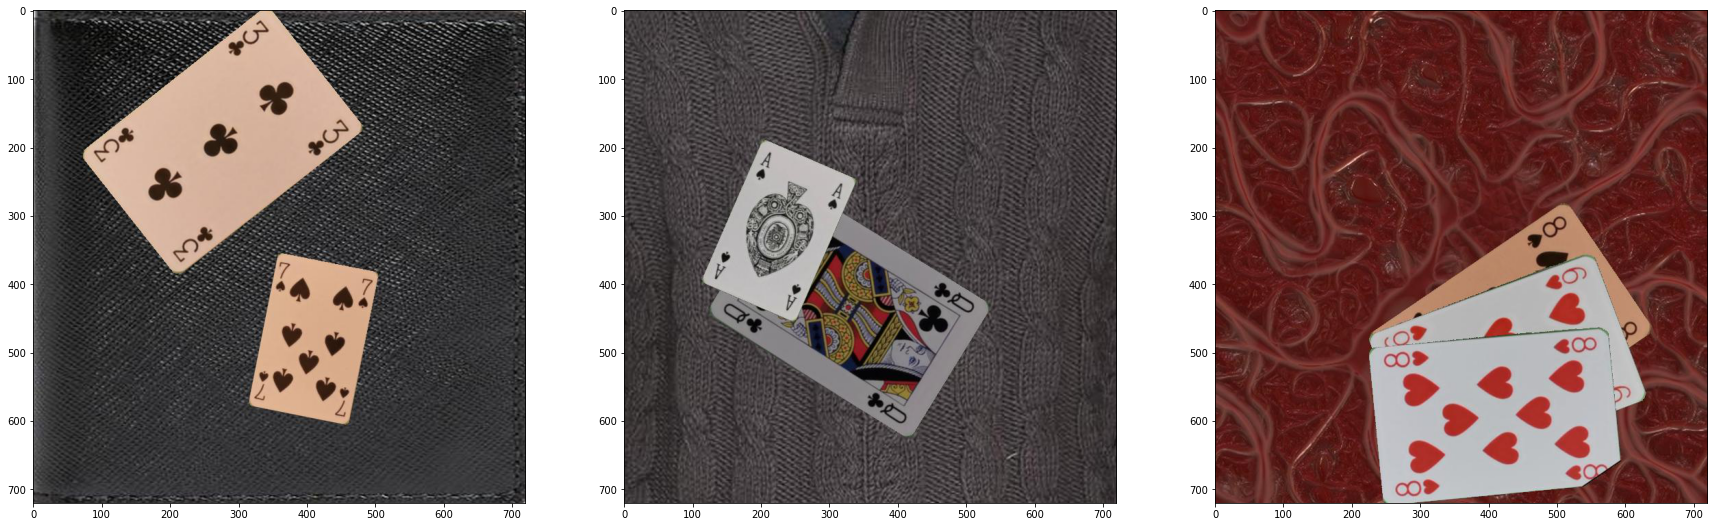

In [ ]:
img_1 = io.imread('or_6.jpg')

img_2 = io.imread('or_12.jpg')

img_3= io.imread('or_15.jpg')


f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(img_1)
ax2.imshow(img_2)
ax3.imshow(img_3)

# 2. Aplicación segmentadores <a name="2"></a>

## 2.1 Ground truth <a name="2.1"></a>

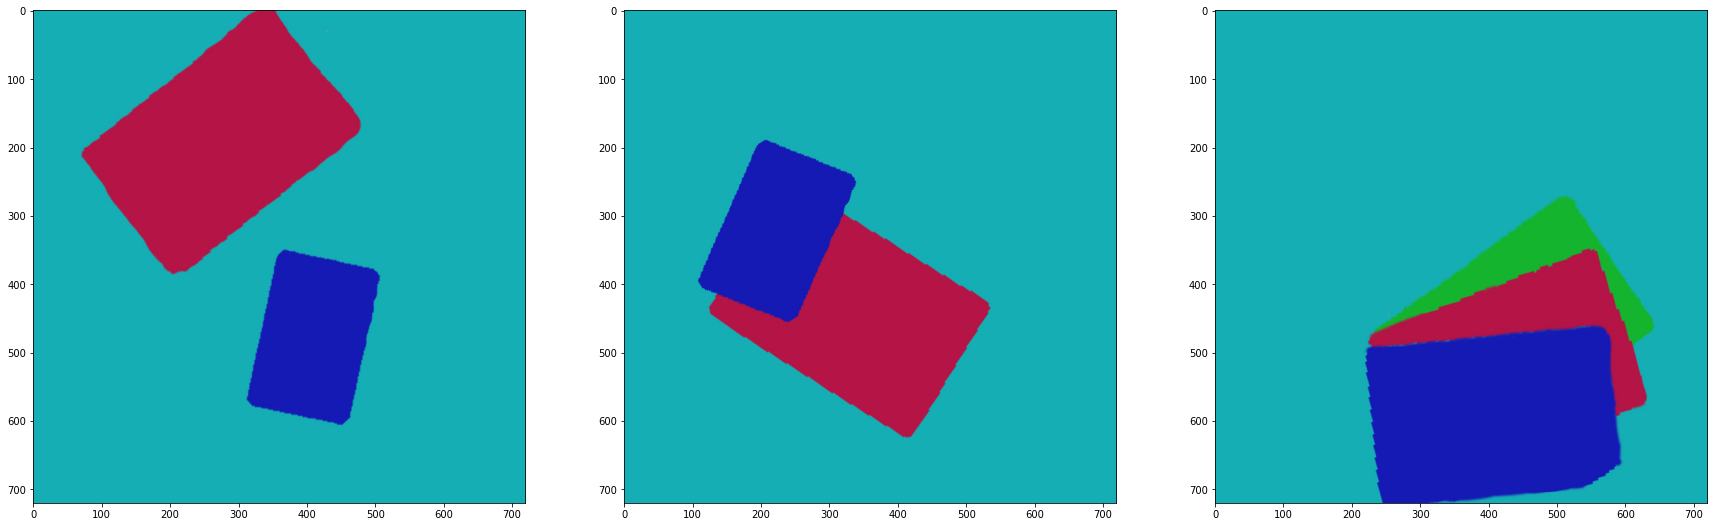

In [ ]:
img_1_g = io.imread('ground_truth_6.jpg')

img_2_g = io.imread('ground_truth_12.jpg')

img_3_g = io.imread('ground_truth_15.jpg')

#img_3_g = io.imread('003743798.jpg')


f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(img_1_g)
ax2.imshow(img_2_g)
ax3.imshow(img_3_g)

## 2.2 K-means <a name="2.2"></a>

In [ ]:
def apply_k_means(img, segments, compactness):
    seg = slic(gaussian(img,5), n_segments= segments , compactness=compactness )
    mask = color.label2rgb(seg)
    res = segmentation.mark_boundaries(img, seg)
    return seg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


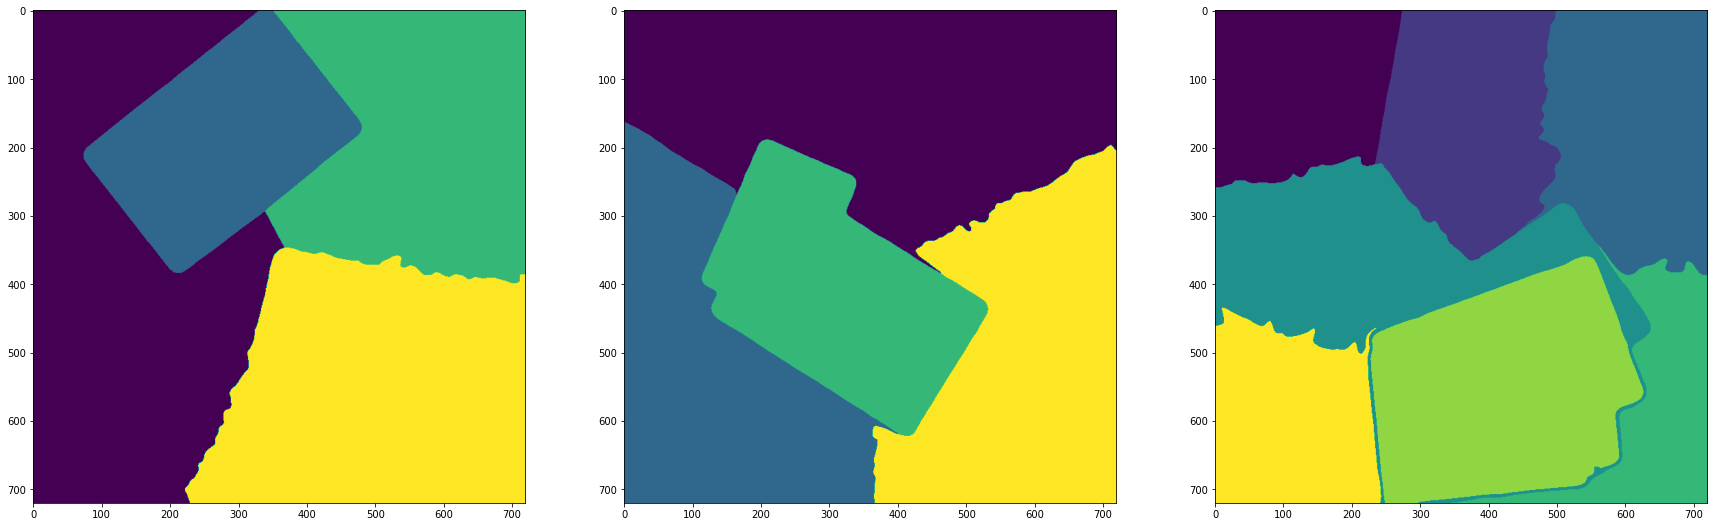

In [ ]:
seg_1_k_means = apply_k_means(img_1, 5, 10)
seg_2_k_means = apply_k_means(img_2, 5, 10)
seg_3_k_means = apply_k_means(img_3, 8, 10)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_k_means)
ax2.imshow(seg_2_k_means)
ax3.imshow(seg_3_k_means)

## 2.3 Watershed <a name="2.3"></a>


En esta función buscamos los marcadores mediante la distancia euclidia con la función distanceTransform y tras ello, la binarizamos y aplicamos una dilatación. Mediante la función findContours buscamos los contornos y los dibujamos con la función drawContours que le pasamos por parámetro los contornos encontrados por la función anterior y así obtener los marcadores que le pasamos al algoritmo de watershed. 



In [ ]:
#https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html
def apply_watershed(img):
    
    # Binarizamos la imagen con la binarizacion OTSU
    bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_OTSU)
    
    # Buscamos la distancia euclidia y la normalizamos
    dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
    dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    euclidian_dist = dist
    
    # Binarizamos la distancia euclidia
    _, dist = cv2.threshold(dist, 0.1, 1.0, cv2.THRESH_BINARY)
    # Realizamos una dilatacion
    kernel1 = np.ones((8,8), dtype=np.uint8)
    dist = cv2.dilate(dist, kernel1)
    
    # Encontramos los contornos 
    dist_8u = dist.astype('uint8')
    contours, _= cv2.findContours(dist_8u, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    markers = np.zeros(dist.shape, dtype=np.int32)
    # Dibujamos los contornos
    for i in range(len(contours)):
        cv2.drawContours(markers, contours, i, (i+1), -1)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplicamos el watershed
    segmentations = watershed(img, markers)
    
    return  segmentations


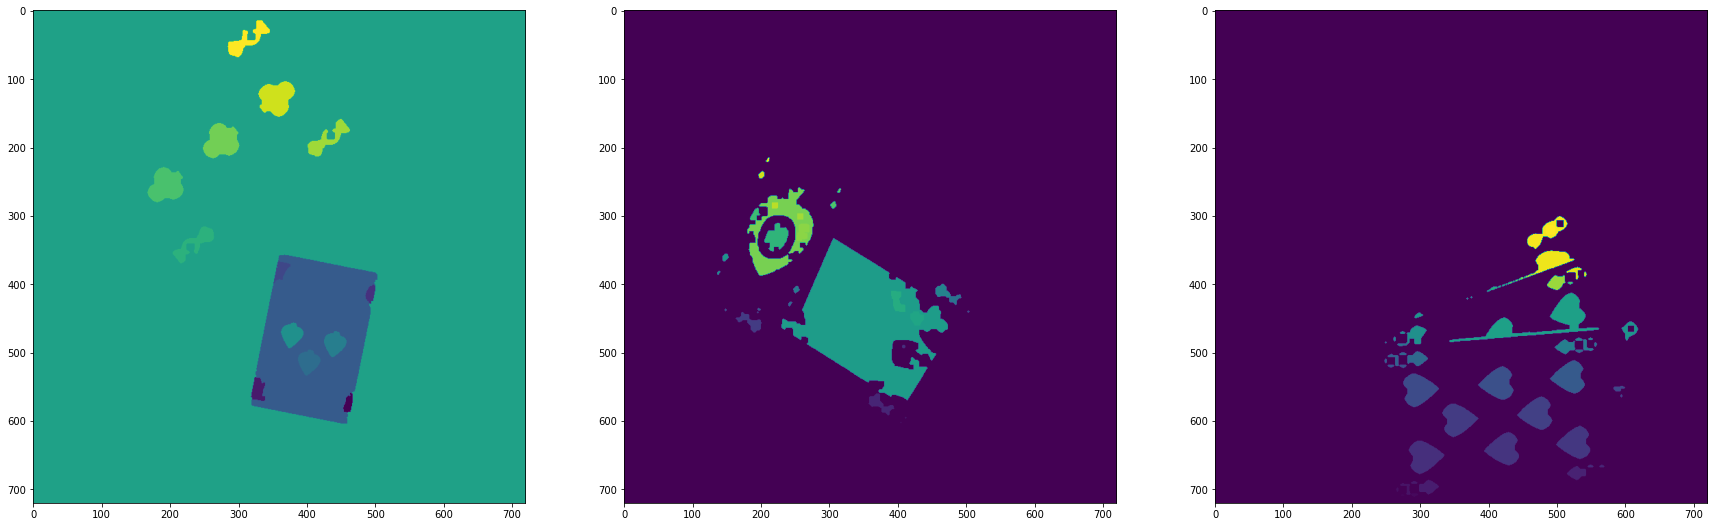

In [ ]:
seg_1_watershed = apply_watershed(img_1)
seg_2_watershed = apply_watershed(img_2)
seg_3_watershed = apply_watershed(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_watershed)
ax2.imshow(seg_2_watershed)
ax3.imshow(seg_3_watershed)

## 2.4 Random walker <a name="2.4"></a>

Para aplicar la función de random walker, definimos un marcador mediante un threshold y así separar el objeto del background. 

In [ ]:
def apply_random_walker(img):
    # Pasamos a float la imagen
    img_f = img_as_float(img)
    # Definimos los marcadores mediante un threshold
    markers = np.zeros(img_f.shape, dtype=np.uint)
    markers[img_f < 0.6 ] = 1
    markers[img_f >= 0.7] = 2
    # Aplicamos la funcion 
    labels = random_walker(img, markers, beta=10, mode='bf')
    labels[labels ==1] = 0
    labels[labels == 2] = 255
    return labels



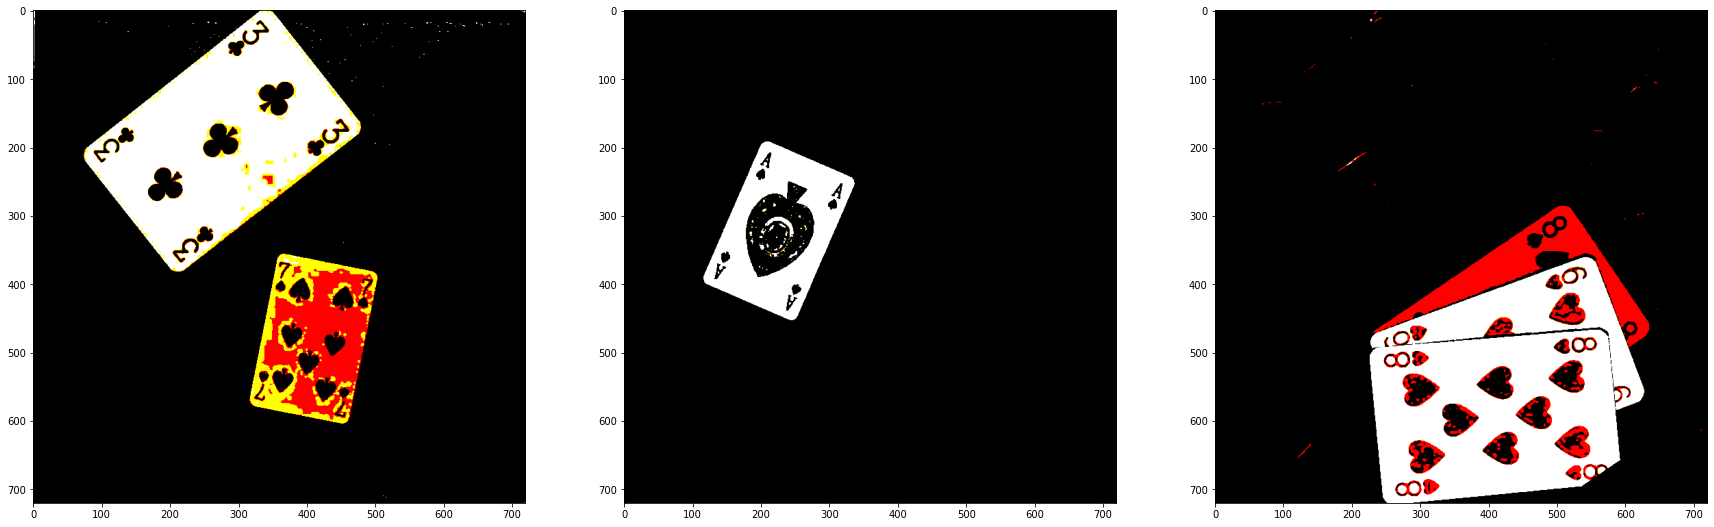

In [ ]:
seg_random_wal_1 = apply_random_walker(img_1)
seg_random_wal_2 = apply_random_walker(img_2)
seg_random_wal_3 = apply_random_walker(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_random_wal_1)
ax2.imshow(seg_random_wal_2)
ax3.imshow(seg_random_wal_3)


## 2.5 Felzenwalb <a name="2.5"></a>

Aplicamos la función de la librería skimage con la imagen de entrada habiéndole aplicado un filtro gaussiano y los parámetros estándard predefinidos. El parámetro scale, cuando más grande, más grande serán los clusteres. El parámetro min size nos indica el minimo tamaño del componente y el parámetro sigma que es el diámetro de un núcleo gaussiano, que se utiliza para suavizar la imagen antes de la segmentación.

In [ ]:
def apply_felzenwalb(img):
    segments = felzenszwalb(gaussian(img,4), scale=300, sigma=0.1, min_size=300)
    return segments
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


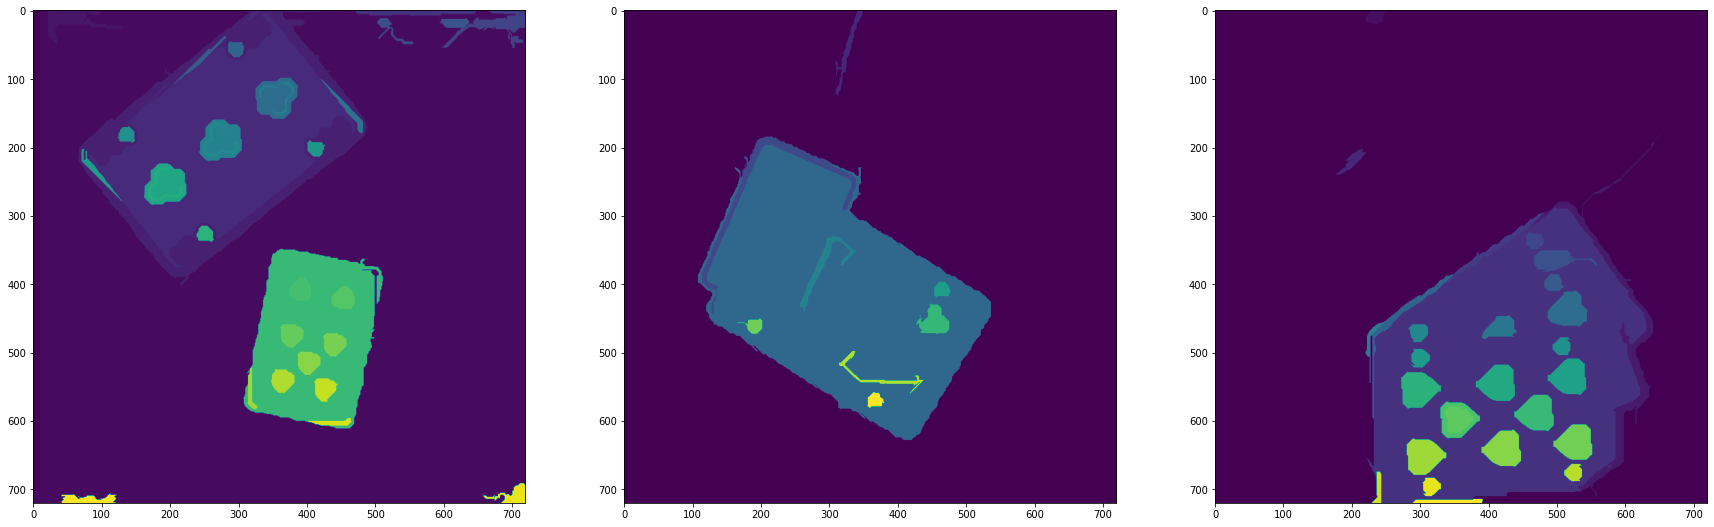

In [ ]:
seg_1_felzen = apply_felzenwalb(img_1)
seg_2_felzen = apply_felzenwalb(img_2)
seg_3_felzen = apply_felzenwalb(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_felzen)
ax2.imshow(seg_2_felzen)
ax3.imshow(seg_3_felzen)

## 2.6 Segmentador morfológico de Otsu <a name="2.5"></a>


In [ ]:
def morf_seg(img):
  img = color.rgb2gray(img)
  Thresh = threshold_otsu(img)
  img = img > Thresh

  Strel = morphology.disk(5)
  img = morphology.opening(img,Strel)
  img = morphology.closing(img,Strel)

  img = img_as_ubyte(img)

  res = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours = res[-2]

  cv2.fillPoly(img,pts=contours,color=(255,255,255))

  img[img == 0] = 0
  img[img == 255] = 1
  return img


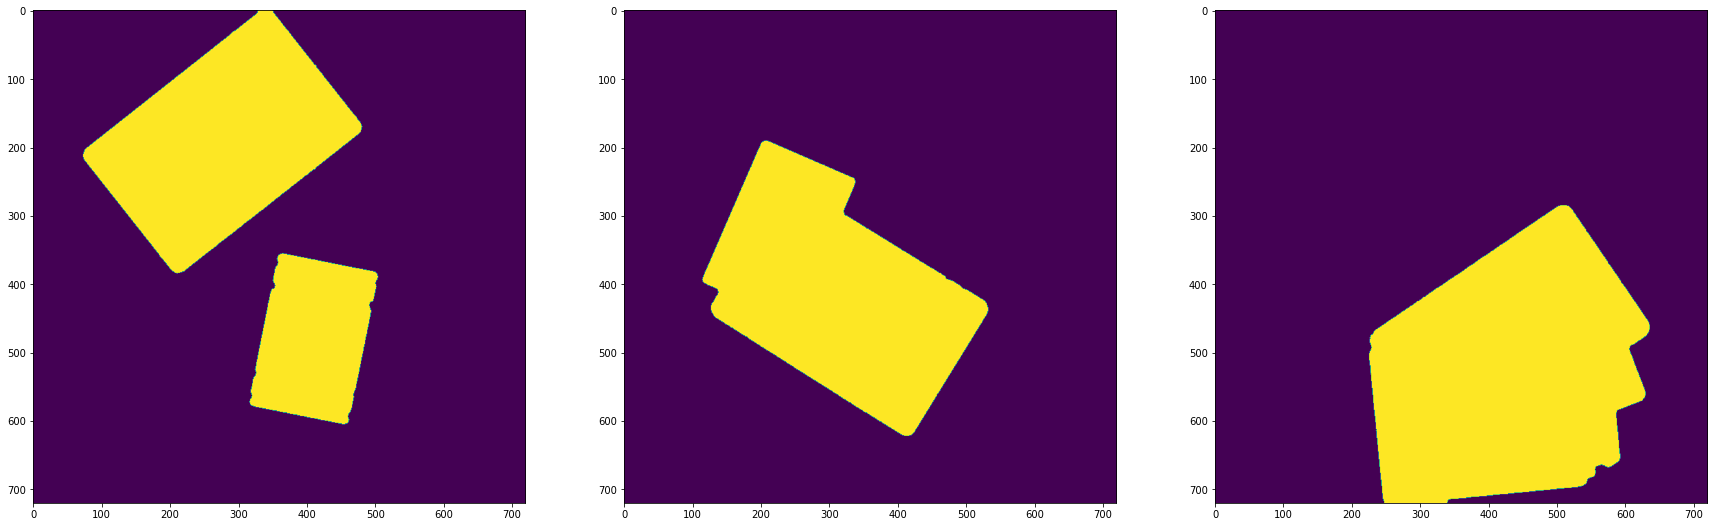

In [ ]:
seg_1_Otsu = morf_seg(img_1)
seg_2_Otsu = morf_seg(img_2)
seg_3_Otsu = morf_seg(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_Otsu)
ax2.imshow(seg_2_Otsu)
ax3.imshow(seg_3_Otsu)

## 2.7 Grafos <a name="2.7"></a>

Para implementar este segmentador, primero debemos de calcular el RAG de la imagen. Para calcular el peso de los bordes, el método que se usa es *rag_mean_color*, que calcula la diferencia de color medio.




In [ ]:
def grafo(img):
  labels = segmentation.slic(gaussian(img,5), n_segments= 20 , compactness=10, multichannel=True)
  rag = graph.rag_mean_color(img, labels, mode='similarity')
  new_labels = graph.cut_normalized(labels, rag)
  rec = segmentation.mark_boundaries(img, new_labels)
 # new_labels = color.label2rgb(new_labels)
  return new_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


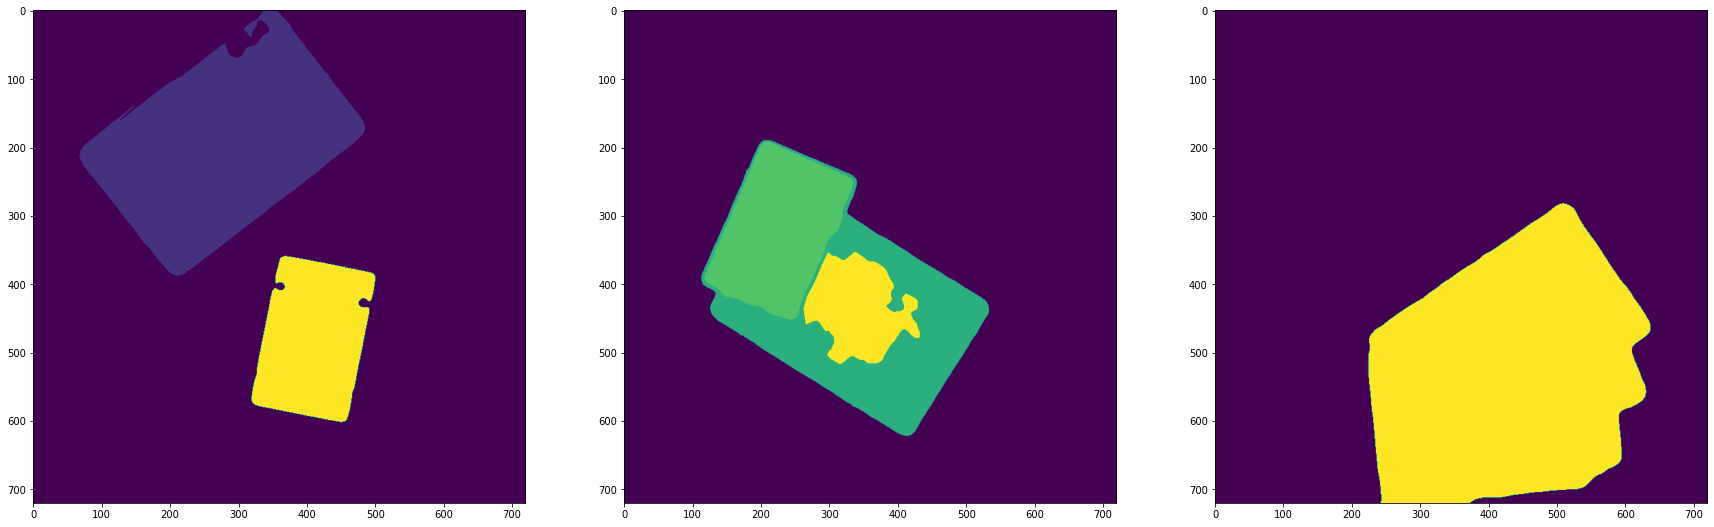

In [ ]:
seg_1_grafos = grafo(img_1)
seg_2_grafos = grafo(img_2)
seg_3_grafos = grafo(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_grafos)
ax2.imshow(seg_2_grafos)
ax3.imshow(seg_3_grafos)

## GrabCut

Para aplicar este algoritmo de grabcut definimos los parámetros necesarios, como la máscara inicial, que en este caso es un rectángulo y bdgModel y fgdModel que son las matrices que usa el algoritmo internamente. 

In [ ]:
def apply_grabcut(img_orig): 
    # Inicializamos la mascara
    rect_final = (100, 200, 600, 600)
    mask = np.zeros(img_orig.shape[:2],np.uint8) 
 
    # Extraemos el rectángulo y marcamos la region de interes en la mascara 
    x,y,w,h = rect_final 
    mask[y:y+h, x:x+w] = 1 

    # Inicializamos los modelos background y el foreground 
    bgdModel = np.zeros((1,65), np.float64) 
    fgdModel = np.zeros((1,65), np.float64) 
 
    # LLamamos la funcion grabcut
    cv2.grabCut(img_orig, mask, rect_final, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT) 
 
    # Extraemos la mascara
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') 
 
    # Aplicamos la mascara a la imagen
    img_orig = img_orig*mask2[:,:,np.newaxis] 

    return img_orig

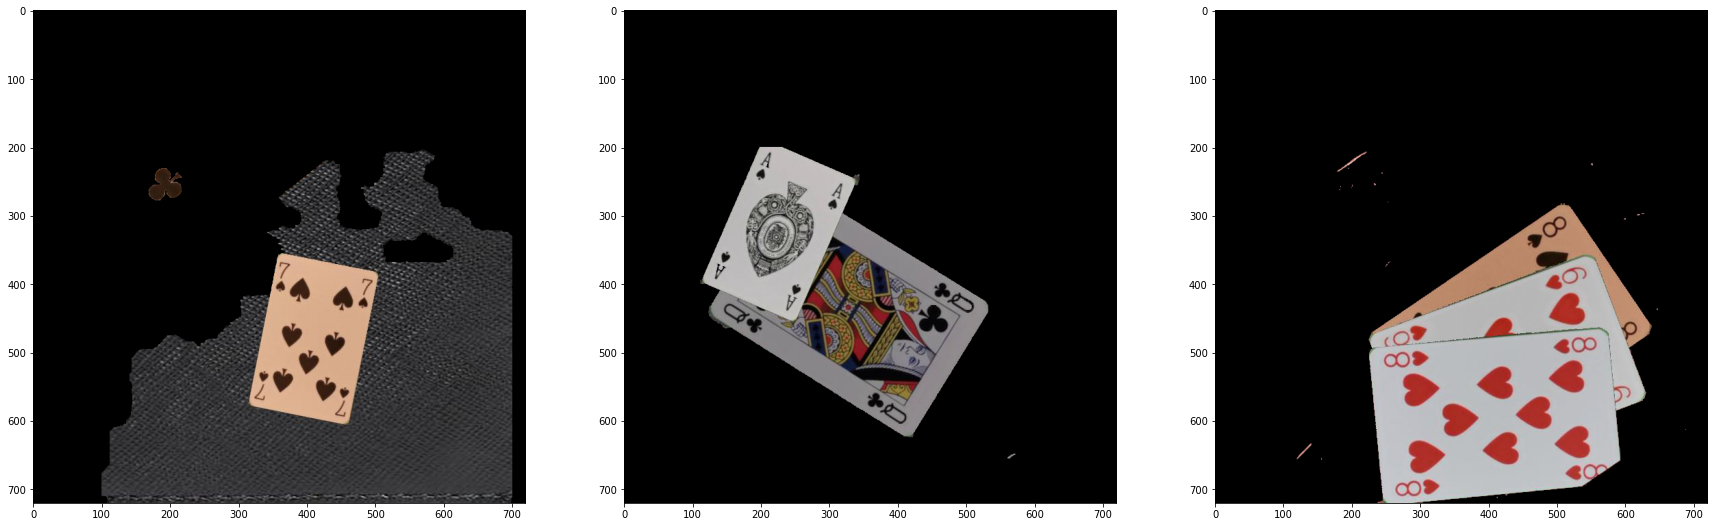

In [ ]:
seg_1_cut = apply_grabcut(img_1)
seg_2_cut = apply_grabcut(img_2)
seg_3_cut = apply_grabcut(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_cut)
ax2.imshow(seg_2_cut)
ax3.imshow(seg_3_cut)

## 2.8 Active contours <a name="2.8"></a>

In [ ]:
def active_contours(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.medianBlur(gray, 9)  # 90%
  #gray = cv2.bilateralFilter(gray,9,125,125)
  flag, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # Find contours
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea,reverse=True) 
  # Select long perimeters only
  perimeters = [cv2.arcLength(contours[i],True) for i in range(len(contours))]
  listindex=[i for i in range(15) if perimeters[i]>perimeters[0]/2]
  numcards=len(listindex)
  # Show image
  imgcont = img.copy()
  [cv2.drawContours(imgcont, [contours[i]], 0, (0,255,0), 5) for i in listindex]
  
  return imgcont


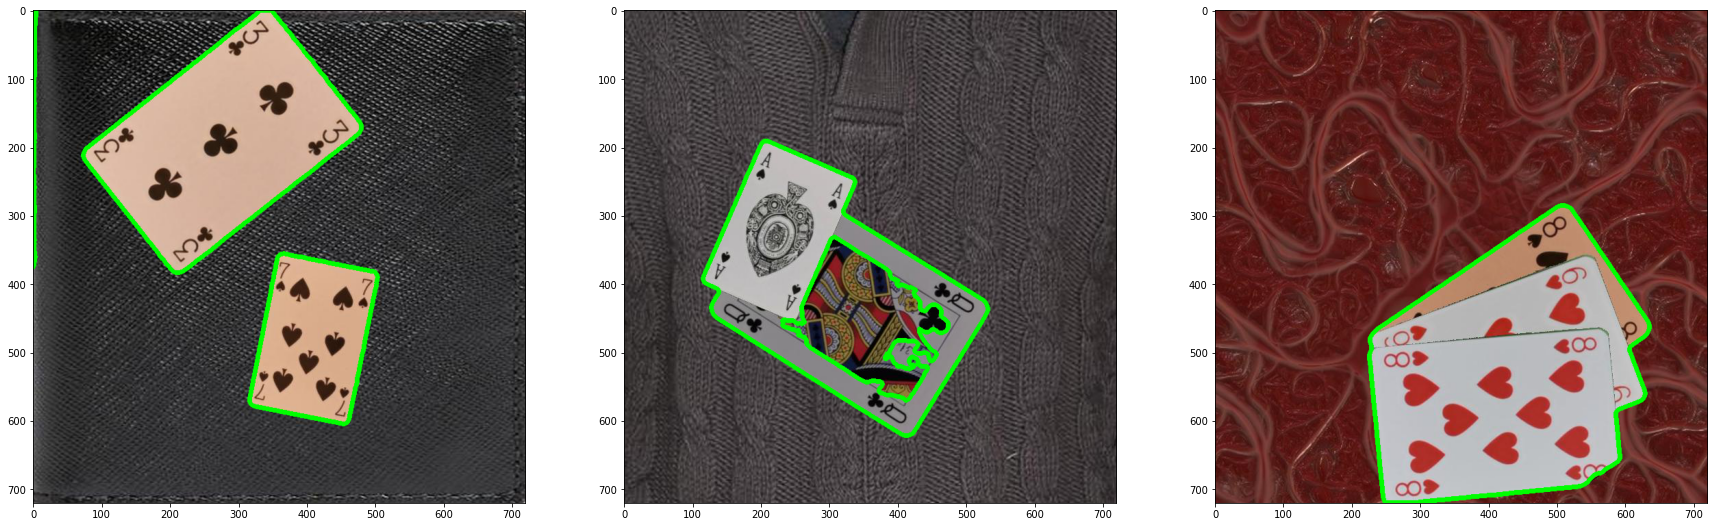

In [ ]:
seg_1_contour = active_contours(img_1)
seg_2_contour = active_contours(img_2)
seg_3_contour = active_contours(img_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_contour)
ax2.imshow(seg_2_contour)
ax3.imshow(seg_3_contour)

# 3. Sistema de votación segmentadores <a name="4"></a>

Para implementar el sistema de votación se ha utilizado la funcion relabel_sequential para poder nivelar las etiquetas del resultado.Tras ello, realizamos un bucle mirando la etiqueta de cada segmentador que tiene asignada ese pixel, y mediante la moda, calculamos la etiqueta que más se repite y guardamos el resultado.

In [ ]:
def apply_moda(datos):
    repeticiones = 0

    for i in datos:
        n = datos.count(i)
        if n > repeticiones:
            repeticiones = n

    moda = [] #Arreglo donde se guardara el o los valores de mayor frecuencia 

    for i in datos:
        n = datos.count(i) # Devuelve el número de veces que x aparece enla lista.
        if n == repeticiones and i not in moda:
            moda.append(i)

    return moda

In [ ]:

def votation_sistem(seg_1, seg_2, seg_3, seg_4, seg_5):
    assert seg_1.shape == seg_2.shape == seg_3.shape == seg_4.shape == seg_5.shape
    result = np.zeros(seg_1.shape, dtype=np.int32)
    
    seg_1, fw, inv = relabel_sequential(seg_1)
    seg_2, fw, inv = relabel_sequential(seg_2)
    seg_3, fw, inv = relabel_sequential(seg_3)
    seg_4, fw, inv = relabel_sequential(seg_4)
    seg_5, fw, inv = relabel_sequential(seg_5)
    for y in range(seg_1.shape[0]):
        for x in range(seg_2.shape[1]):
            values = [seg_1[y,x], seg_2[y,x], seg_3[y,x], seg_4[y,x], seg_5[y,x]]
            #moda = threshhold(mode(values), 2)
            moda = apply_moda(values)
            #print(type(moda))
            result[y,x] = moda[0]
    result = color.label2rgb(result)
    return result

#result = votation_sistem(seg_2_watershed, seg_2_k_means, seg_2_felzen, seg_2_grafos, seg_2_Otsu)
#io.imshow(result)

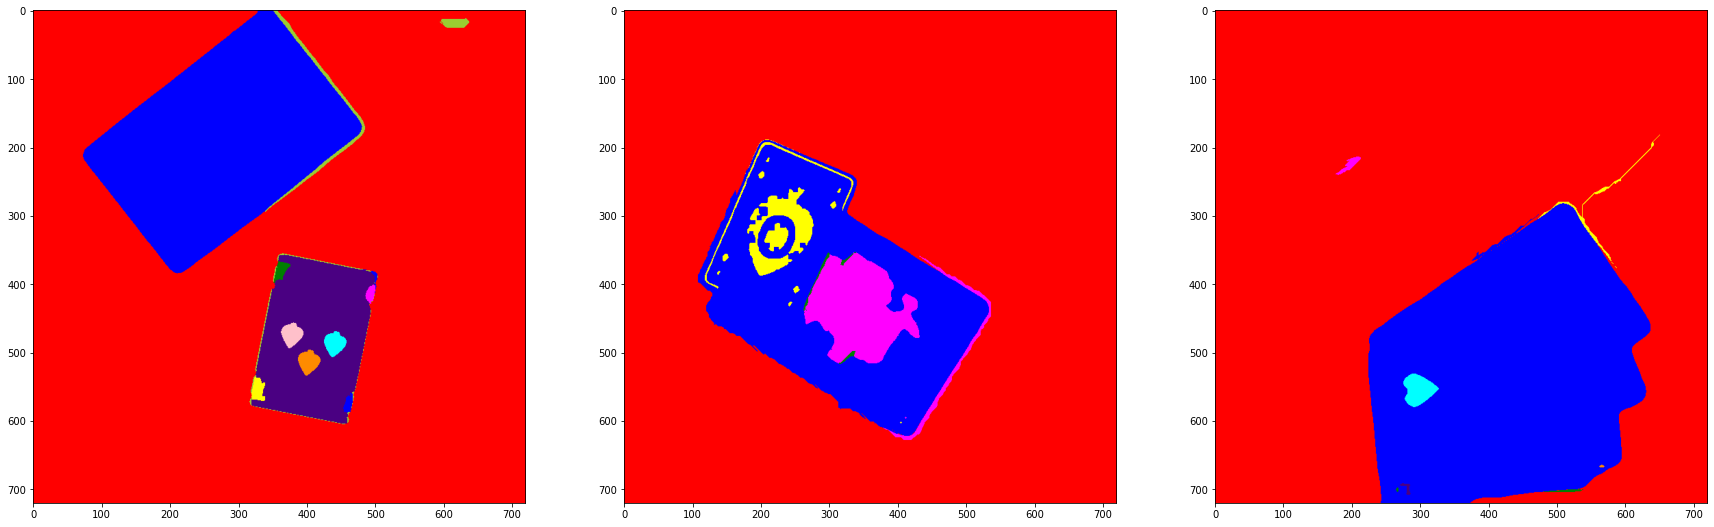

In [ ]:
seg_1_v = votation_sistem(seg_1_watershed, seg_1_k_means, seg_1_felzen, seg_1_grafos, seg_1_Otsu)
seg_2_v = votation_sistem(seg_2_watershed, seg_2_k_means, seg_2_felzen, seg_2_grafos, seg_2_Otsu)
seg_3_v = votation_sistem(seg_3_watershed, seg_3_k_means, seg_3_felzen, seg_3_grafos, seg_3_Otsu)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(seg_1_v)
ax2.imshow(seg_2_v)
ax3.imshow(seg_3_v)

# 4. Evaluación de los segmentadores <a name="3"></a>

Para evaluar los segmentadores utilizamos la métrica F2 que combina la precisión y el recall calculados mediante la función adapted_rand_error

In [ ]:
def factor_f(image, ground_truth):
    if (image.shape != ground_truth.shape):
        ground_truth =  cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    assert image.shape == ground_truth.shape
    relab_gt, fw_gt, inv_gt = relabel_sequential(ground_truth)
    relab, fw, inv = relabel_sequential(image)
    error, precision, recall = adapted_rand_error(img_as_ubyte(relab_gt), img_as_ubyte(relab))
    factor_f = 2*(precision*recall)/(precision+recall)
    return factor_f

f_k_means_1 = factor_f(seg_1_k_means, img_1_g)
f_k_means_2 = factor_f(seg_2_k_means, img_2_g)
f_k_means_3 = factor_f(seg_3_k_means, img_3_g)

f_w_1 = factor_f(seg_1_watershed, img_1_g)
f_w_2 = factor_f(seg_2_watershed, img_2_g)
f_w_3 = factor_f(seg_3_watershed, img_3_g)

f_grafos_1 = factor_f(seg_1_grafos, img_1_g)
f_grafos_2 = factor_f(seg_2_grafos, img_2_g)
f_grafos_3 = factor_f(seg_3_grafos, img_3_g)

f_rand_walker_1  = factor_f(seg_random_wal_1,img_1_g )
f_rand_walker_2  = factor_f(seg_random_wal_2, img_2_g)
f_rand_walker_3  = factor_f(seg_random_wal_3, img_3_g)

f_fw_1  = factor_f(seg_1_felzen,img_1_g )
f_fw_2  = factor_f(seg_2_felzen, img_2_g)
f_fw_3 = factor_f(seg_3_felzen, img_3_g)

f_m_1  = factor_f(seg_1_Otsu,img_1_g )
f_m_2  = factor_f(seg_2_Otsu, img_2_g)
f_m_3 = factor_f(seg_3_Otsu, img_3_g)

f_grab_cut_1  = factor_f(seg_1_cut,img_1_g )
f_grab_cut_2  = factor_f(seg_2_cut, img_2_g)
f_grab_cut_3  = factor_f(seg_3_cut, img_3_g)

f_contour_1  = factor_f(seg_1_contour,img_1_g)
f_contour_2  = factor_f(seg_2_contour, img_2_g)
f_contour_3  = factor_f(seg_3_contour, img_3_g)

f_vot_1  = factor_f(seg_1_v,img_1_g)
f_vot_2  = factor_f(seg_2_v, img_2_g)
f_vot_3  = factor_f(seg_3_v, img_3_g)

df=pd.DataFrame([[f_k_means_1,f_k_means_2,f_k_means_3],
                [f_w_1,f_w_2,f_w_3],
                [f_grafos_1,f_grafos_2,f_grafos_3],
                [f_rand_walker_1,f_rand_walker_2,f_rand_walker_3],
                [f_grab_cut_1,f_grab_cut_2,f_grab_cut_3],
                [f_contour_1,f_contour_2,f_contour_3],
                 [f_m_1,f_m_2,f_m_3],
                [f_fw_1, f_fw_2, f_fw_3],
                [f_vot_1, f_vot_2, f_vot_3]],
                columns=['Imagen 1','Imagen 2','Imagen 3'],
                index=['K means','Watershed','Grafos','Random Walker','Grab Cut','Active Contours','Morfologico', 'Fenzelwalb', 'Votacion'])

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 3 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 3 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 6 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 15 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 30 fits in uint8
  return convert(image, np.uint8, 

In [ ]:
df

,Imagen 1,Imagen 2,Imagen 3
K means,0.518562,0.521310,0.329650
Watershed,0.826404,0.853824,0.755087
Grafos,0.965865,0.984031,0.952483
Random Walker,0.444578,0.395572,0.425944
Grab Cut,0.242312,0.472400,0.446162
Active Contours,0.031540,0.034661,0.037753
Morfologico,0.959702,0.972973,0.947339
Fenzelwalb,0.930550,0.971375,0.955230
Votacion,0.534699,0.565883,0.488347


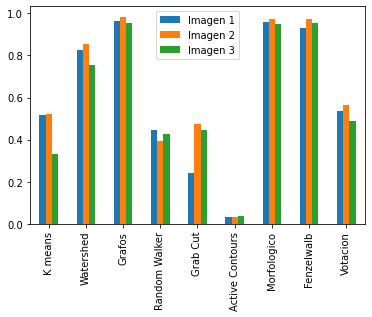

In [ ]:
df.plot(kind='bar')

In [2]:
df2 = pd.DataFrame()
for text in ['active_contours', 'fenzelwalb', 'kmeans', 'grab_cut', 'grafos', 'morf', 'randm_walker', 'votation', 'water']:
  df_aux = pd.read_csv(f'{text}.txt')
  df2 = pd.concat([df2, df_aux], axis=1)
df2.head()

,Active_cotours,Fenzelwalb,Kmeans,Grab_cut,Grafos,Otsu,Random Walker,Votation,Watershed
0,0.015072,0.764802,0.399726,0.434536,0.931678,0.952851,0.419764,0.487176,0.579976
1,0.021083,0.962769,0.311728,0.374254,0.959627,0.963834,0.430448,0.524251,0.832983
2,0.034738,0.970882,0.281324,0.471936,0.990014,0.976167,0.395573,0.554274,0.886419
3,0.037825,0.956608,0.339802,0.445888,0.952427,0.949475,0.426020,0.496338,0.780288
4,0.018034,0.903908,0.331922,0.445612,0.450976,0.715706,0.437675,0.572200,0.690150


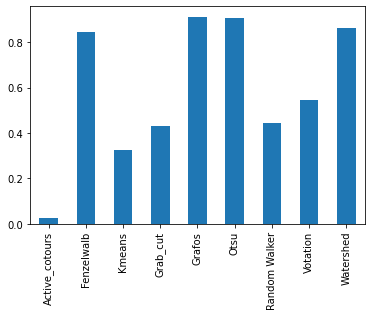

In [3]:
df2.mean().plot(kind='bar')